# **FaceExpreessionRecogniser using Affectnet+KDEF (Greyscaled)**
* Trained on Tesla P100-PCIE-16GB
* 100 epochs trained (~15h) with Checkpoints
* 81% val_acc (80% val_acc after 30-40 epochs)
* TF version: 2.3.1
* Hub version: 0.10.0

In [1]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

TF version: 2.3.1
Hub version: 0.10.0
Number of accelerators:  1


In [2]:
import subprocess
import pprint

sp = subprocess.Popen(['nvidia-smi', '-q'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

out_str = sp.communicate()
out_list = str(out_str[0]).split('\\n')

out_dict = {}

for item in out_list:
    print(item)

b'
==============NVSMI LOG==============

Timestamp                                 : Wed Jan 13 00:18:00 2021
Driver Version                            : 450.51.06
CUDA Version                              : 11.0

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla P100-PCIE-16GB
    Product Brand                         : Tesla
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 0324317003740
    GPU UUID                              : GPU-078436ad-8e55-a

In [3]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
# Names of the integer classes, i.e., 0 -> afraid, 1 -> angry, etc.
class_names = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [4]:
train_dir = "../input/affectnetkdefhaarcascade/Affectnet4k" 
test_val_dir = "../input/affectnetkdefhaarcascade/KDEF"

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet.preprocess_input).flow_from_directory(directory=train_dir,target_size=(224,224),classes=class_names,batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet.preprocess_input).flow_from_directory(directory=test_val_dir,target_size=(224,224),classes=class_names,batch_size=32)

Found 23480 images belonging to 7 classes.
Found 1120 images belonging to 7 classes.


In [6]:
imgs,labels = next(valid_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 32, figsize=(40,40))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

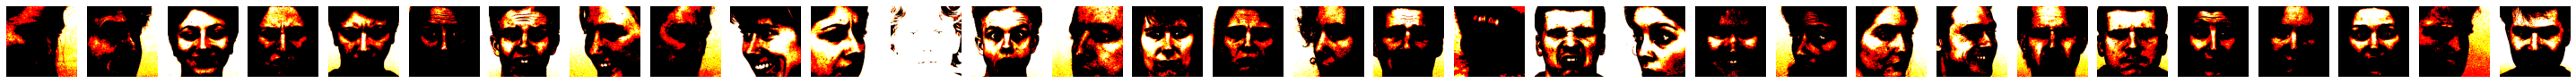

In [8]:
plotImages(imgs)

In [9]:
for l in labels:
    maximum = np.max(l)
    index_of_maximum = np.where(l == maximum)
    
    print(class_names[index_of_maximum[0][0]])

angry
sad
happy
angry
angry
surprised
afraid
happy
angry
happy
afraid
neutral
surprised
neutral
neutral
sad
neutral
afraid
surprised
disgusted
surprised
happy
surprised
neutral
happy
afraid
angry
afraid
neutral
surprised
angry
angry


In [10]:
# import math
# datagen_kwargs = dict(rescale=1./255)
# dataflow_kwargs = dict(color_mode="rgb",target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
#                    interpolation="bilinear")

# valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     **datagen_kwargs, validation_split=0.99)
# valid_generator = valid_datagen.flow_from_directory(
#     test_val_dir, subset="validation", shuffle=False, **dataflow_kwargs) #test_val_dir

# do_data_augmentation = True #@param {type:"boolean"}
# if do_data_augmentation:
#   train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#       rotation_range=40,
#       horizontal_flip=True,
#       width_shift_range=0.2, 
#       height_shift_range=0.2,
#       shear_range=0.2, zoom_range=0.2,
#       **datagen_kwargs)
# else:
#   train_datagen = valid_datagen
# train_generator = train_datagen.flow_from_directory(
#     train_dir, subset="training", shuffle=True, **dataflow_kwargs) #train_dir


# number_of_valid_examples = len(valid_generator.filenames)
# number_of_generator_calls = math.ceil(number_of_valid_examples / (1.0 * BATCH_SIZE)) 
# # 1.0 above is to skip integer division

# valid_labels = []

# for i in range(0,int(number_of_generator_calls)):
#     valid_labels.extend(np.array(valid_generator[i][1]))

In [11]:
do_fine_tuning = True #@param {type:"boolean"}

In [12]:
from tensorflow.keras.layers import InputLayer
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning), # False = transfer learning, True = fine-tuning
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_batches.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])  
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 2,232,839
Non-trainable params: 34,112
_________________________________________________________________


[1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]


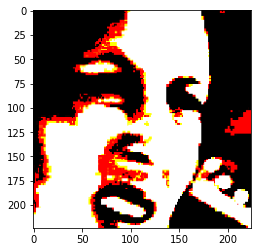

In [14]:
from skimage import io
from pylab import *

x,y = train_batches.next()
x1,y1 =valid_batches.next()

for i in range(0,2):
    image = x[i]
    print(y[i])
    imshow(image)

In [15]:
from keras.callbacks import ModelCheckpoint
#Atutomatic rename with epoch number and val accuracy:
#save the best weights over the same file with the model name
modelName= "MobileNet"
#filepath="checkpoints/"+modelName+"_bestweights_epoch-{epoch:02d}-val_accuracy-{val_accuracy:.2f}.hdf5"
filepath=modelName+"_bestweights_epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the model

In [16]:
steps_per_epoch = train_batches.samples // train_batches.batch_size  #train_generator.samples = num_of_train_samples
validation_steps = valid_batches.samples // valid_batches.batch_size #valid_generator.samples = num_of_valid_samples
# Train the classifier.
hist = model.fit(train_batches, 
                 epochs=40, 
                 steps_per_epoch= steps_per_epoch, 
                 validation_data=valid_batches,
                 callbacks=callbacks_list,
                 validation_steps=validation_steps).history

Epoch 1/40
733/733 [==============================] - ETA: 0s - loss: 1.6123 - accuracy: 0.4619
Epoch 00001: val_accuracy improved from -inf to 0.68036, saving model to MobileNet_bestweights_epochs:001-val_accuracy:0.680.hdf5
733/733 [==============================] - 331s 452ms/step - loss: 1.6123 - accuracy: 0.4619 - val_loss: 1.1797 - val_accuracy: 0.6804
Epoch 2/40
733/733 [==============================] - ETA: 0s - loss: 1.3937 - accuracy: 0.5774
Epoch 00002: val_accuracy improved from 0.68036 to 0.81607, saving model to MobileNet_bestweights_epochs:002-val_accuracy:0.816.hdf5
733/733 [==============================] - 133s 181ms/step - loss: 1.3937 - accuracy: 0.5774 - val_loss: 0.9366 - val_accuracy: 0.8161
Epoch 3/40
733/733 [==============================] - ETA: 0s - loss: 1.2914 - accuracy: 0.6320
Epoch 00003: val_accuracy improved from 0.81607 to 0.84196, saving model to MobileNet_bestweights_epochs:003-val_accuracy:0.842.hdf5
733/733 [==============================] - 136

Epoch 29/40
733/733 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.9967
Epoch 00029: val_accuracy did not improve from 0.86250
733/733 [==============================] - 134s 183ms/step - loss: 0.5532 - accuracy: 0.9967 - val_loss: 0.8712 - val_accuracy: 0.8500
Epoch 30/40
733/733 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.9968
Epoch 00030: val_accuracy did not improve from 0.86250
733/733 [==============================] - 133s 182ms/step - loss: 0.5517 - accuracy: 0.9968 - val_loss: 0.8894 - val_accuracy: 0.8446
Epoch 31/40
733/733 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.9965
Epoch 00031: val_accuracy did not improve from 0.86250
733/733 [==============================] - 136s 185ms/step - loss: 0.5519 - accuracy: 0.9965 - val_loss: 0.8666 - val_accuracy: 0.8518
Epoch 32/40
733/733 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.9967
Epoch 00032: val_accuracy did not improve 

# Train the saved model

In [17]:
# import numpy as np
# from numpy.testing import assert_allclose
# from keras.models import Sequential, load_model
# from keras.layers import LSTM, Dropout, Dense
# from keras.callbacks import ModelCheckpoint
# from tensorflow.keras.models import model_from_json
# import tensorflow_hub as hub

# reloaded_model =  tf.keras.models.load_model('../input/faceexprafterfirstcheckpoint/epochs_038-val_accuracy_0.809.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})
# print(reloaded_model.get_config())

# #Get input shape from model.get_config()
# reloaded_model.build((None, 224, 224, 3))
# reloaded_model.summary()

# steps_per_epoch = train_generator.samples // train_generator.batch_size  #train_generator.samples = num_of_train_samples
# validation_steps = valid_generator.samples // valid_generator.batch_size #valid_generator.samples = num_of_valid_samples
# # Train the classifier.
# hist = reloaded_model.fit(train_generator, 
#                  epochs=43, 
#                  steps_per_epoch= steps_per_epoch, 
#                  validation_data=valid_generator,
#                  callbacks=callbacks_list,
#                  validation_steps=validation_steps).history

 Save the model and last weights 

In [18]:
timestr = time.strftime("%Y%m%d_%H%M%S")

# serialize model to JSON
model_json = model.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")

# SAVING

In [19]:
import fileinput
# Saving the model in the workspace
model.save('MobileNet-Kaggle.h5')

In [20]:
# # load json and create model
# json_file = open('20190107_220958_InceptionTutorial_MODEL_3.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)

In [21]:
# # load weights into new model
# model.load_weights("InceptionTutorial_bestweights.hdf5")

# Model Acc&Loss + Confusion Matrix

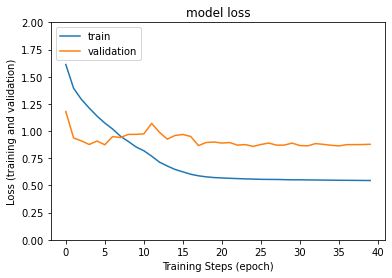

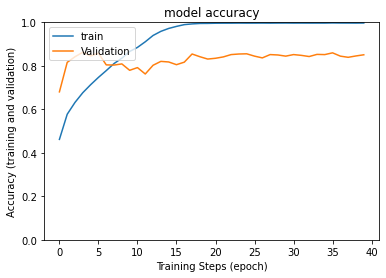

In [24]:
# # list all data in history
# print(hist.history())

# summarize history for loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylim([0,2])
plt.title('model loss')
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps (epoch)')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylim([0,1])
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps (epoch)')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


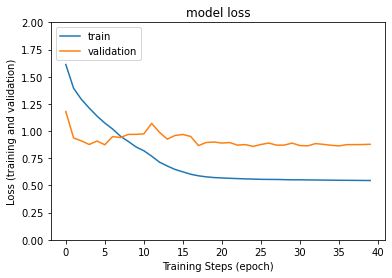

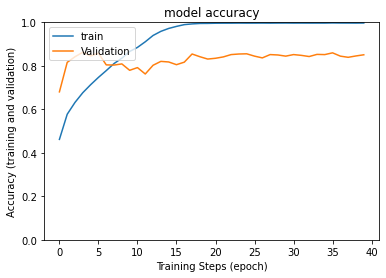

In [26]:
# # list all data in history
print(hist.keys())

# summarize history for loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylim([0,2])
plt.title('model loss')
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps (epoch)')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylim([0,1])
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps (epoch)')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

Confusion Matrix
[[28 19 26 24 28 19 20]
 [22 18 25 26 24 24 22]
 [19 23 27 19 19 29 24]
 [28 23 27 26 29 13 14]
 [25 22 26 21 26 18 20]
 [28 24 24 16 17 22 26]
 [25 21 32 24 20 16 22]]
Classification Report
              precision    recall  f1-score   support

      afraid       0.16      0.17      0.17       164
       angry       0.12      0.11      0.12       161
   disgusted       0.14      0.17      0.16       160
       happy       0.17      0.16      0.16       160
     neutral       0.16      0.16      0.16       158
         sad       0.16      0.14      0.15       157
   surprised       0.15      0.14      0.14       160

    accuracy                           0.15      1120
   macro avg       0.15      0.15      0.15      1120
weighted avg       0.15      0.15      0.15      1120



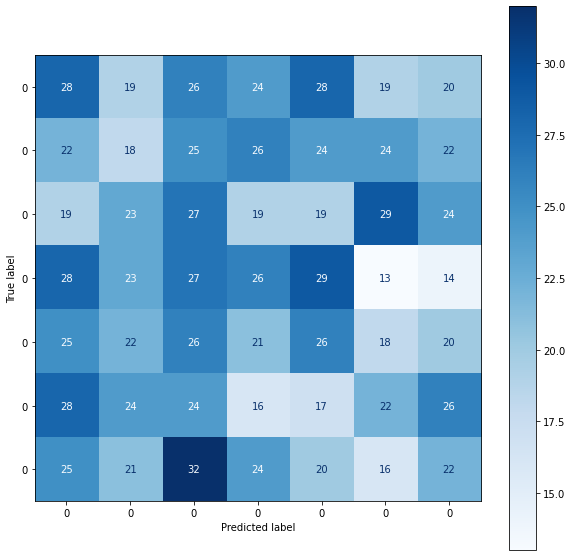

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Y_pred = model.predict(valid_batches, valid_batches.samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_batches.classes, y_pred)
print(cm)
print('Classification Report')
target_names = list(train_batches.class_indices.keys())
print(classification_report(valid_batches.classes, y_pred, target_names=target_names))


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=valid_batches.classes)

# make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Testing

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
# from skimage import transform
import cv2
import sys


    


# # Names of the integer classes, i.e., 0 -> afraid, 1 -> angry, etc.
class_names = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

def load(filePath):
    image = cv2.imread(filePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )

#     print("[INFO] Found {0} Faces.".format(len(faces)))
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 224, 0), 2)
        roi_color = image[y:y + h, x:x + w]
        np_image = image
        np_image = np.array(np_image).astype('float32')/255
        np_image = np.resize(np_image, (224, 224, 3))
        np_image = np.expand_dims(np_image, axis=0)
        model.predict(np_image)        #change here the model
        x = class_names
        plt.imshow(image)
        plt.axis('off')
        y_pred=model.predict(np_image)
#         print(x[np.argmax(y_pred,axis=1)[0]]) #model.predict_classes(image) is a 1 element array with the result of the prediction
        plt.text(3, 8, x[np.argmax(y_pred,axis=1)[0]], fontsize=15, style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
        plt.show()

for filename in os.listdir("../input/faceexprtestimages/DorinNet/DorinNet/"):
    if filename.endswith(".jpg"): 
#         classify(os.path.join("../input/faceexprtestimages/DorinNet/DorinNet/", filename))
        load(os.path.join("../input/faceexprtestimages/DorinNet/DorinNet/", filename))
        continue
    else:
        continue

FileNotFoundError: [Errno 2] No such file or directory: '../input/faceexprtestimages/DorinNet/DorinNet/'

In [31]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_batches.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

NameError: name 'valid_generator' is not defined